In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')
warn()

In [ ]:
#Load the dataset
mtcars = sm.datasets.get_rdataset("mtcars", "datasets", cache=True).data
df = pd.DataFrame(mtcars)
df.sample(5)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
rownames,,,,,,,,,,,
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Pontiac Firebird,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


#Explore the data

In [ ]:
#check shape of the data
df.shape

(32, 11)

In [ ]:
#Check for missing values in each column of the dataset
print(df.isnull().sum())

mpg     0
cyl     0
disp    0
hp      0
drat    0
wt      0
qsec    0
vs      0
am      0
gear    0
carb    0
dtype: int64


To understand whether any of the features are correlated to one another, different data visualizations, such as pair plots and correlation heatmaps, can show potential signs of multicollinearity. This can subsequently indicate the need for a dimensionality reduction.

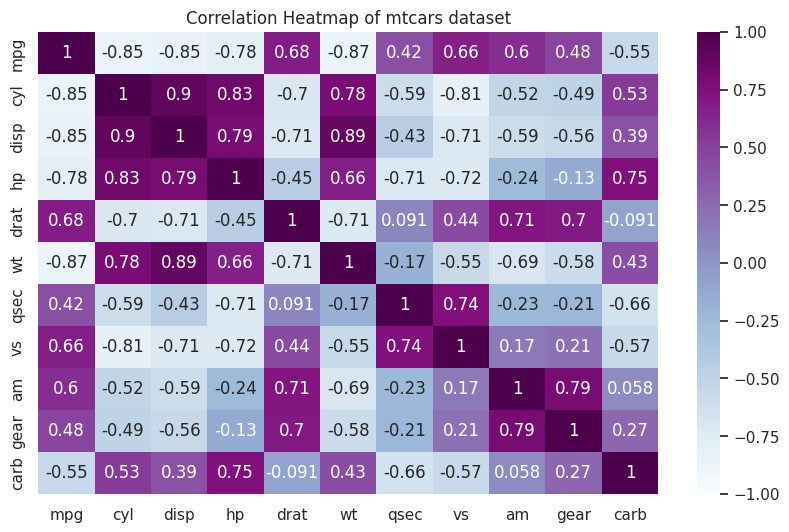

In [ ]:
#Create a heatmap
corr = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Correlation Heatmap of mtcars dataset")
plt.show()

The heatmap computes and displays the correlation between two variables. The values range from -1 to 1, where -1 indicates perfect negative correlation, 0 indicates no correlation, and 1 denotes perfect positive correlation. In this data set, there is a strong positive correlation of 0.9 between cylinders (cyl) and displacement (disp), meaning that as one increases, the other also increases. There is also a strong negative correlation between mpg and cyl (-.85), mpg and disp (-.85), and mpg and wt (-.87). This means that as displacement, weight, and the number of cylinders increase, the fuel efficiency (mpg) tends to decrease.

#Split the dataset into training and test set


In [ ]:
features = df.columns[1:]
target = df.columns[0]
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardise data points through feature scaling
* Next, you normalize the data to ensure that the scale of your predictors does not negatively impact variable selection as the scale of your variable does affect the size of your coefficients. Scaling your variables with a mean of zero and a standard deviation of one is a common feature scaling technique. This allows the lasso model to select the most important features more accurately.

In [ ]:
#scaling and centering the data
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
#Initialize lasso regression model
model = Lasso(max_iter=10000) #default alpha is 1
model.fit(X_train_scaled,y_train)

y_pred = model.predict(X_test_scaled)

#Calculate R-squared
rsquared = r2_score(y_test, y_pred)
print(f"R-squared: {rsquared}")

#Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

R-squared: 0.7682870857302199
Mean Squared Error: 9.264828079502825


The R-squared and mean squared error (MSE) for this model is 0.77 and 9.26, respectively. To see which coefficients shrunk down to zero, you will plot your coefficients in both a DataFrame and a graph.

Text(0.5, 1.0, 'Coefficient values with increasing values of alpha')

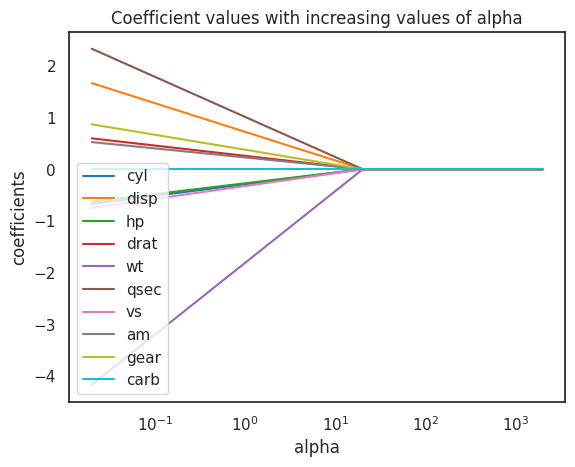

In [ ]:
coeff = pd.Series(model.coef_, index=features)
coeff

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    model.set_params(alpha=a)
    model.fit(X_train_scaled, y_train)
    coefs.append(model.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.legend(features)
ax.grid(False)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficient values with increasing values of alpha")

In your DataFrame, you see that 7 of the 10 variables have shrunk down to zero. According to this model, there are three features that are key predictors of mpg, which are the number of cylinders, horsepower, and the weight of the vehicle. However, when you observe the line graph, it looks like the model might have dropped some variables, like disp, due to high collinearity, which might have also had good predictive power. As you can see, lasso regression is helpful in reducing the number of features in a model to some of the most important ones, but it's not without its limitations

#Optimize model and hyperparameter tuning
* You want the lowest possible value of MSE for the optimal lasso model, and you find this by trying different values of alpha through grid search. GridSearchCV helps you to conduct this optimization through cross-validation, allowing you to find or confirm the best value for the alpha hyperparameter.

In [ ]:
alphas = {"alpha": 10.0 ** np.arange(-5, 6)}
grid_search = GridSearchCV(model, alphas, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled,y_train)

print(f"Best value for lambda : ", grid_search.best_params_)
print("Best score for cost function: ", grid_search.best_score_)

Best value for lambda :  {'alpha': 1.0}
Best score for cost function:  -10.203459268430183


This grid search confirms that the default alpha value of 1 is, in fact, the optimal value for this hyperparameter.